# The Impact of Generative Artificial Intelligence on Higher Education

### Introduction
Generative Artificial intelligence (GenAI) is transforming higher education, influencing teaching, learning, and administrative practices. As GenAI becomes more prevalent in educational settings, there is a growing body of research examining its implications, benefits, and challenges in higher education. This notebook aims to explore this research landscape by conducting a two-part analysis.

### Part 1: Bibliometric Analysis
In the first phase, we perform a bibliometric analysis using data from SCOPUS, aiming to summarize the state of the research in this field. Specifically, our objectives include:
- **Quantifying Publication Trends ->** Determining how research on GenAI in higher education has grown over recent years.
- **Identifying Key Contributors ->** Recognizing influential authors, institutions, and countries that are leading research efforts.
- **Research Themes and Collaboration Networks ->** Exploring recurring themes, as well as collaborations and partnerships in the literature.

### Part 2: Text Mining Analysis
Following the bibliometric analysis, we will apply text mining techniques to the articles themselves. This phase will enable us to delve deeper into the content, uncovering nuanced insights into how AI is being discussed and understood in higher education contexts. In particular, we aim to:
- **Extract Key Topics ->** Use natural language processing (NLP) methods to identify key themes and subtopics.
- **Analyze Sentiment and Context ->** Examine how GenAI’s impact is portrayed in higher education, focusing on sentiments around its benefits and challenges.
- **Identify Emerging Trends ->** Detect emerging applications or innovative uses of AI in education.

### Methodology
We will use SCOPUS API to aquire articles based on the following search query:
``` "impact" AND "high* education" AND ( "generative artificial intelligence" OR "GenAI" ) ```. Our approach will follow these steps:
1. **Data collection ->** Retrieve bibliometric data from SCOPUS, including article titles, abstracts, authors, affiliations, and publication years.
2. **Data Processing ->** Organize and clean the data for analysis, ensuring it is suitable for quantitative and qualitative assessments.
3. **Analysis:**
    * **Publication Trends ->** Analyze the number of publications over time to identify growth patterns.
    * **Key Contributors ->** Identify leading authors, institutions, and countries in AI research within higher education.
    * **Research Themes ->** Use text mining techniques to uncover major themes and topics in the literature.
4. **Exploring Potential Machine Learning Applications ->** Briefly discuss potential applications of machine learning techniques to further analyze or extend insights from the bibliometric data.

### Expected outcomes
This analysis will contribute to understanding the broader impact of GenAI on higher education, offering valuable perspectives for academics, practitioners, and policymakers aiming to leverage AI technologies to enhance educational experiences and outcomes.


========================================================================================================================================

#### Importing required libraries and modules

In [5]:
import os
import sys
import requests
import json
import pickle
import math 
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Add custom module that provides auxiliar functions
aux_modules_path = os.path.abspath(os.path.join('./scripts'))
if aux_modules_path not in sys.path:
    sys.path.append(aux_modules_path)


#### API Key Configuration

In [6]:
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv('API_KEY')

print(f"API Key: {API_KEY}")

API Key: dc7c18eddcd470e03ed6f72cf4a11585


#### Data Collection
This will take some time due to the high amount of articles retrieved. This will retrieve 5000 articles, even though the query results in over 50000 articles, due to SCOPUS API imposing a maximum cap of 5000 on the number of results retrieved per query. 

In [7]:
# variable to store the data returned by the SCOPUS API
API_DATA = None

# query to send to SCOPUS API
user_query = '"impact" AND "high* education" AND ( "generative artificial intelligence" OR "GenAI" )'

def fetch_all_articles():
    articles = []
    total_results = None
    start = 0
    count = 25  # results per page, max 25
    
    while True:
        params = {
            'query': user_query,
            'apiKey': API_KEY,
            'start': start,
            'count': count
        }
        
        response = requests.get("https://api.elsevier.com/content/search/scopus", params=params)
        
        if response.status_code != 200:
            if response.status_code == 429:
                print("You have hit the limit quota:", response.status_code)
                break
            if len(articles) >= 5000:
                print("Hit the rate limit of results retrieved.")
                break
            print("Failed to retrieve data:", response.status_code)
            break
        
        data = response.json()
        entries = data.get("search-results", {}).get("entry", [])
        
        if total_results == None and 'opensearch:totalResults' in data.get("search-results", {}):
            total_results = int(data.get("search-results", {}).get("opensearch:totalResults"))

        if not entries:
            break
        
        # Process each entry and add it to the articles list
        for entry in entries:
            article_data = {
                "title": entry.get("dc:title", "No title"),
                "author_names": [author.get("authname") for author in entry.get("author", [])],
                "publication_name": entry.get("prism:publicationName"),
                "publication_date": entry.get("prism:coverDate"),
                "doi": entry.get("prism:doi"),
                "cited_by_count": entry.get("citedby-count", "0"),
                "abstract": entry.get("dc:description", "No abstract"),
                "keywords": [kw.get("keyword") for kw in entry.get("keywords", [])],
                "affiliations": [
                    {
                        "name": affil.get("affilname", "No affiliation name"),
                        "city": affil.get("affiliation-city", "No city"),
                        "country": affil.get("affiliation-country", "No country")
                    }
                    for affil in entry.get("affiliation", [])
                ]
            }
            articles.append(article_data)
        
        # Update the start index for the next batch
        start += count

    print("Number of articles retrieved: ", len(articles))
    print(f"Total number of articles: {total_results}")
    return pd.DataFrame(articles)

API_DATA = fetch_all_articles()

Number of articles retrieved:  2348
Total number of articles: 2348


However, this does only provide us with results from the year of 2024, hindering our research. Therefore, we will use the exported csv from SCOPUS, in order to more accuratly study the topic at hand. Even then, it is only possible to export the data of 20000 articles.

In [8]:
# variable to store the data import from the CSV
CSV_DATA = None

CSV_DATA = pd.read_csv('..\data\scopus.csv')
CSV_DATA.columns

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\3323738601.py:4: SyntaxWarning: invalid escape sequence '\d'
  CSV_DATA = pd.read_csv('..\data\scopus.csv')


Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'Author Keywords',
       'Index Keywords', 'Molecular Sequence Numbers', 'Chemicals/CAS',
       'Tradenames', 'Manufacturers', 'Funding Details', 'Funding Texts',
       'References', 'Correspondence Address', 'Editors', 'Publisher',
       'Sponsors', 'Conference name', 'Conference date', 'Conference location',
       'Conference code', 'ISSN', 'ISBN', 'CODEN', 'PubMed ID',
       'Language of Original Document', 'Abbreviated Source Title',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')

In [9]:
CSV_DATA[:3]

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,ISBN,CODEN,PubMed ID,Language of Original Document,Abbreviated Source Title,Document Type,Publication Stage,Open Access,Source,EID
0,Baek C.; Tate T.; Warschauer M.,"Baek, Clare (57207736649); Tate, Tamara (56727...",57207736649; 56727937300; 6603955476,“ChatGPT seems too good to be true”: College s...,2024,Computers and Education: Artificial Intelligence,7,NaN,100294,NaN,...,NaN,NaN,NaN,English,Comput. Educ.,Article,Final,All Open Access; Gold Open Access,Scopus,2-s2.0-85204737193
1,Yan D.; Zhang S.,"Yan, Da (57192956833); Zhang, Shuxian (5929817...",57192956833; 59298172300,L2 writer engagement with automated written co...,2024,Humanities and Social Sciences Communications,11,1,1086,NaN,...,NaN,NaN,NaN,English,Hum. Soc. Sci. Comm,Article,Final,All Open Access; Gold Open Access,Scopus,2-s2.0-85202037916
2,Baucon A.; de Carvalho C.N.,"Baucon, Andrea (35321983500); de Carvalho, Car...",35321983500; 35387869400,Can AI Get a Degree in Geoscience? Performance...,2024,Geoheritage,16,4,121,NaN,...,NaN,NaN,NaN,English,Geoheritage,Article,Final,All Open Access; Hybrid Gold Open Access,Scopus,2-s2.0-85206563891


In [10]:
print("Articles retrieved from the API: ", len(API_DATA))
print("Articles imported from the CSV: ", len(CSV_DATA))

Articles retrieved from the API:  2348
Articles imported from the CSV:  2168


## Part 1: Bibliometric analysis

### What?

#### Publication quantity and types

C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\536136628.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publication_type_counts.values, y=publication_type_counts.index, palette="viridis")


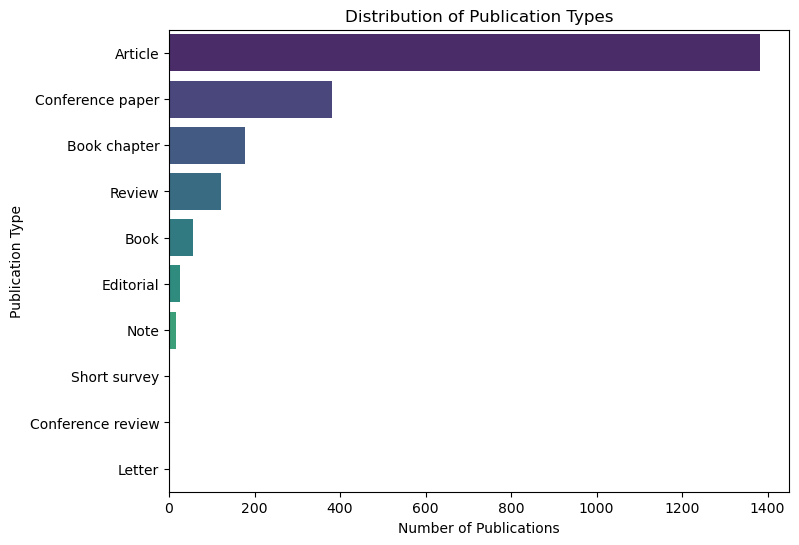

In [11]:
# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def plot_publication_types(df, opt):
    publication_type_counts = None
    if opt == 0:
        publication_type_counts = df['Document Type'].value_counts()
    elif opt == 1:
        publication_type_counts = df['publication_type'].value_counts()

        
    plt.figure(figsize=(8, 6))
    sns.barplot(x=publication_type_counts.values, y=publication_type_counts.index, palette="viridis")
    plt.title("Distribution of Publication Types")
    plt.xlabel("Number of Publications")
    plt.ylabel("Publication Type")
    plt.show()

plot_publication_types(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

#### Top Keywords
Only works with data from the CSV, has the standard API does not give data about the keywords

C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\92897346.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="coolwarm")


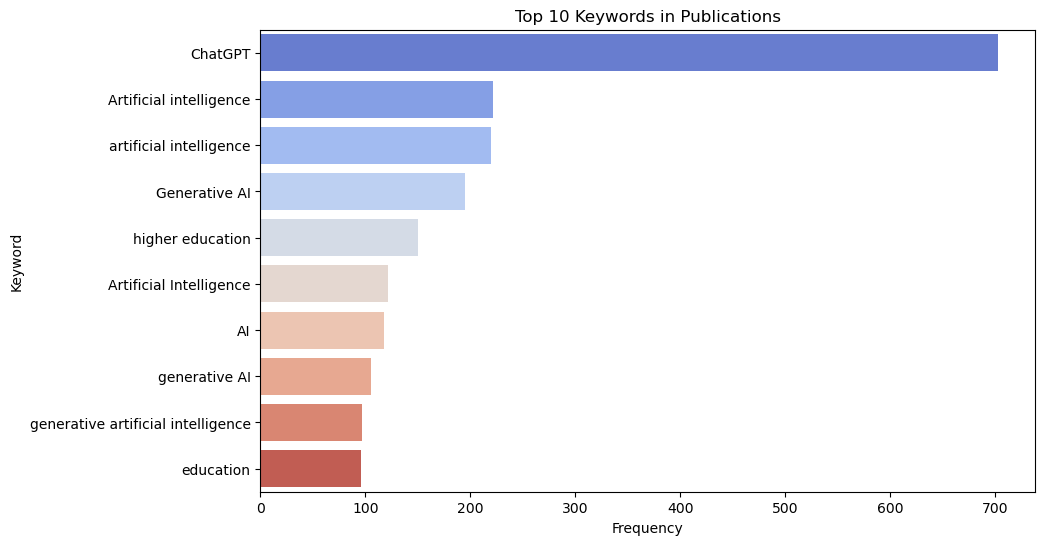

In [12]:
def plot_top_keywords(df):
    all_keywords = [kw.strip() for keywords in df['Author Keywords'].dropna() for kw in keywords.split(';')]
    top_keywords = pd.Series(all_keywords).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="coolwarm")
    plt.title("Top 10 Keywords in Publications")
    plt.xlabel("Frequency")
    plt.ylabel("Keyword")
    plt.show()

if CSV_DATA is not None:
    plot_top_keywords(CSV_DATA)
else:
    print("Please use CSV, as the API does not provide the necessary data to plot this information")

#### Open Access vs Closed Access Counts

<Axes: xlabel='Open Access'>

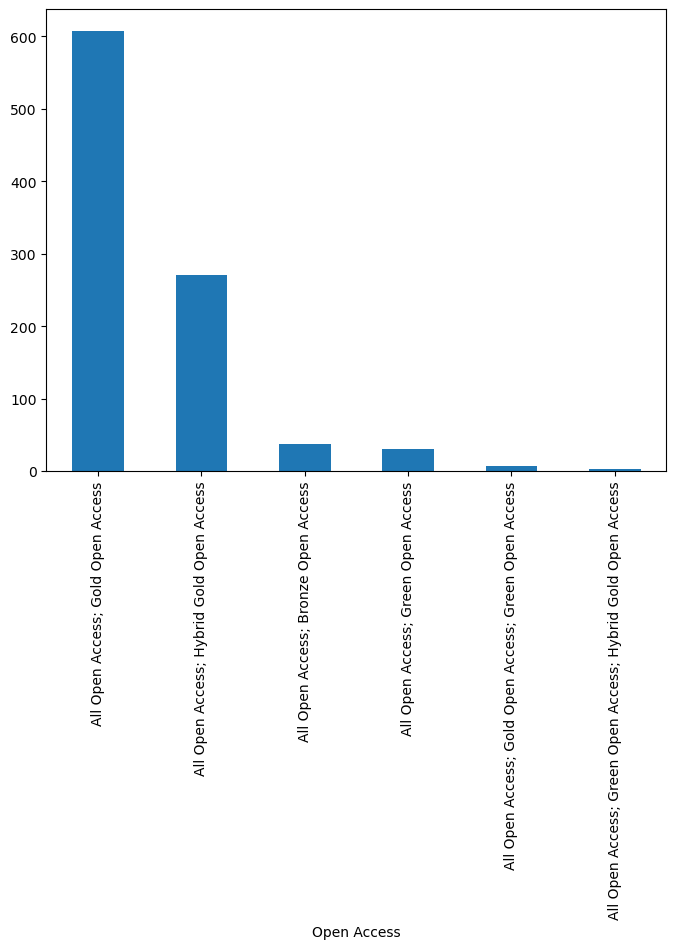

In [13]:
def access(df):
   return df['Open Access'].value_counts()

open_access_counts = access(CSV_DATA if CSV_DATA is not None else API_DATA)

# Bar Chart
plt.figure(figsize=(8, 6))
open_access_counts.plot(kind='bar')

### Where?

#### Top journals and conferences

C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\3463577392.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette="magma")


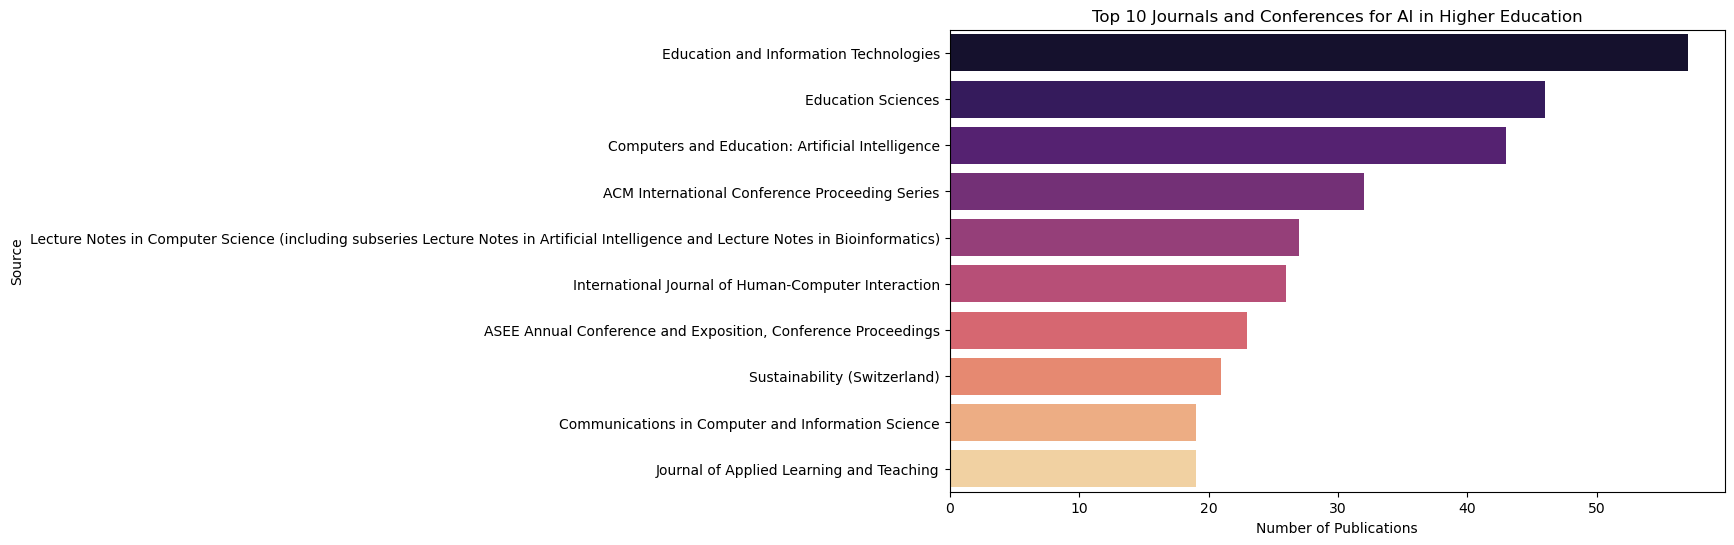

In [14]:
# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def plot_relevant_sources(df, opt):
    top_sources = df['Source title' if opt == 0 else 'publication_name'].value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_sources.values, y=top_sources.index, palette="magma")
    plt.title("Top 10 Journals and Conferences for AI in Higher Education")
    plt.xlabel("Number of Publications")
    plt.ylabel("Source")
    plt.show()

plot_relevant_sources(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

#### Number of publications over time

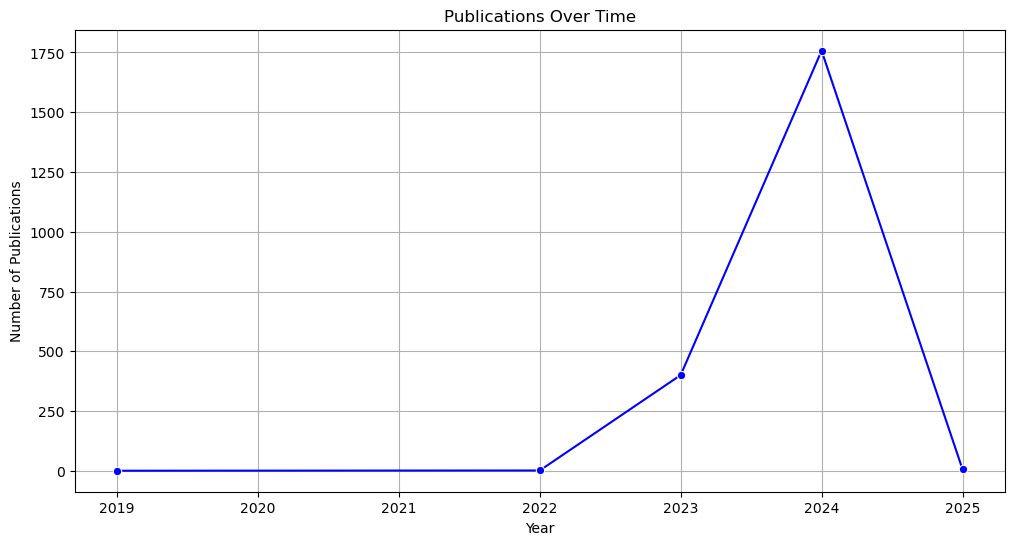

In [15]:
def plot_publication_distribution(df):
    publications_per_year = df['Year'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=publications_per_year.index, y=publications_per_year.values, marker="o", color="b")
    plt.title("Publications Over Time")
    plt.xlabel("Year")
    plt.ylabel("Number of Publications")
    plt.grid(True)
    plt.show()

plot_publication_distribution(CSV_DATA if CSV_DATA is not None else API_DATA)

#### Number of Documents per Year

Unique 'Open Access' Values: ['All Open Access; Gold Open Access'
 'All Open Access; Hybrid Gold Open Access' nan
 'All Open Access; Green Open Access'
 'All Open Access; Bronze Open Access'
 'All Open Access; Gold Open Access; Green Open Access'
 'All Open Access; Green Open Access; Hybrid Gold Open Access']


<Figure size 1000x600 with 0 Axes>

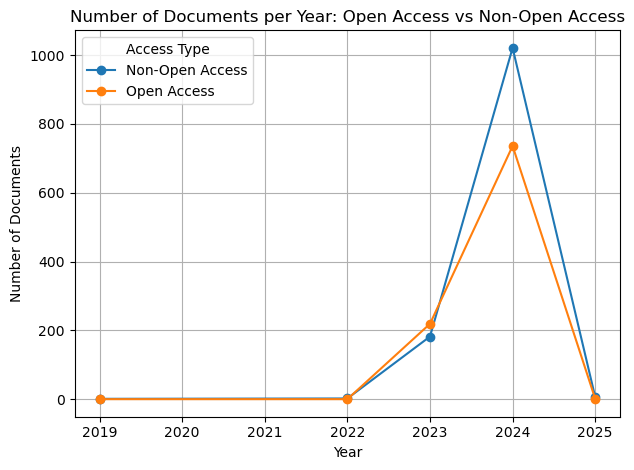

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_open_access_distribution(data):

    # Display unique values in 'Open Access' column to check for inconsistencies
    unique_access_values = data['Open Access'].unique()
    print("Unique 'Open Access' Values:", unique_access_values)

    # Create a binary column indicating open access status
    data['Is Open Access'] = data['Open Access'].str.contains("All Open Access", na=False)

    # Group data by 'Year' and 'Is Open Access', counting documents
    document_counts = data.groupby(['Year', 'Is Open Access']).size().unstack(fill_value=0)

    # Plot the data
    plt.figure(figsize=(10, 6))
    document_counts.plot(kind='line', marker='o', title='Number of Documents per Year: Open Access vs Non-Open Access')
    plt.xlabel("Year")
    plt.ylabel("Number of Documents")
    plt.legend(["Non-Open Access", "Open Access"], title="Access Type")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage example:
plot_open_access_distribution(CSV_DATA if CSV_DATA is not None else API_DATA)


#### Citations per Year

<Figure size 1000x600 with 0 Axes>

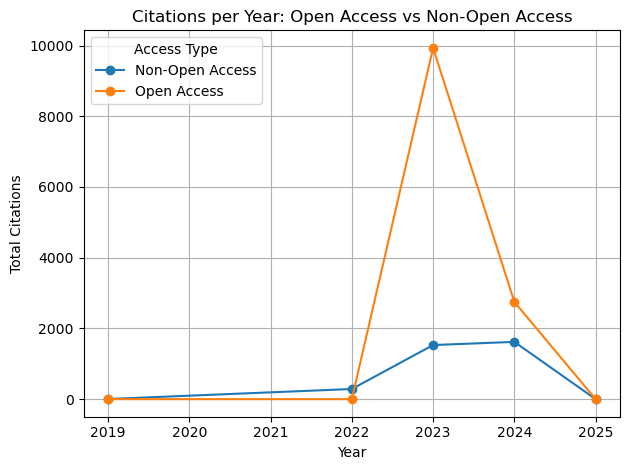

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_citations(data):
    
    # Add a column to indicate open access status
    data['Is Open Access'] = data['Open Access'].str.contains("All Open Access", na=False)

    # Group by year and open access status, then calculate the sum of citations
    grouped_data = data.groupby(['Year', 'Is Open Access'])['Cited by'].sum().unstack(fill_value=0)

    # Plot the data
    plt.figure(figsize=(10, 6))
    grouped_data.plot(kind='line', marker='o', title='Citations per Year: Open Access vs Non-Open Access')
    plt.xlabel("Year")
    plt.ylabel("Total Citations")
    plt.legend(["Non-Open Access", "Open Access"], title="Access Type")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage example:
analyze_citations(CSV_DATA if CSV_DATA is not None else API_DATA)



### Who?

#### Most prominent authors
Only works with data from the CSV, has the standard API does not give data about the authors

C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\2882732728.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_citations_series.values, y=author_citations_series.index, palette="coolwarm")


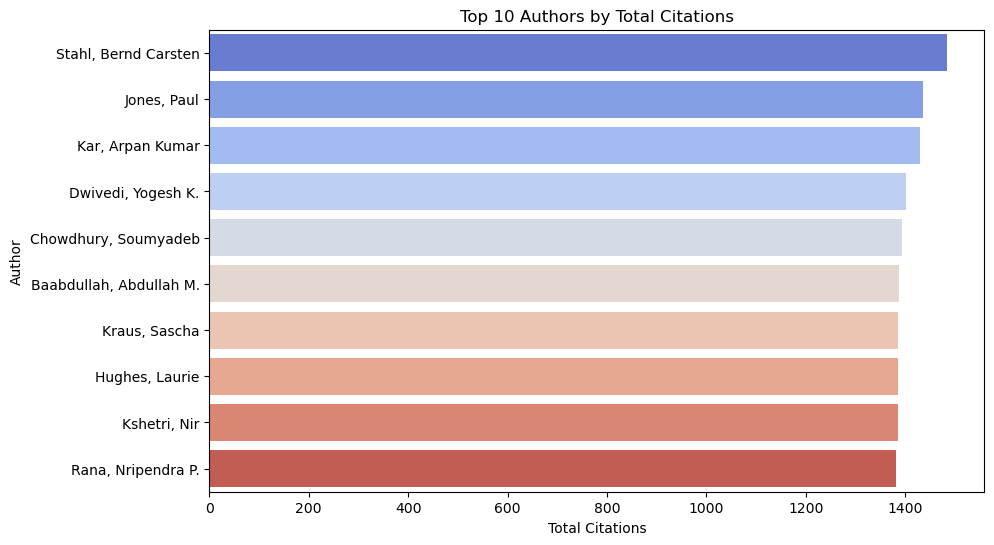

In [18]:
def plot_most_prominent_authors(df):
    # Function to clean the names of the authors
    # They are stored like this: Kahlon, Yuval (57210749964);
    def clean_author_name(author_string):
        # regex to clean anything inside parentheses, parentheses included
        cleaned_name = re.sub(r'\(.*?\)', '', author_string).strip()
        return cleaned_name
    
    # Iterate over every article and get every participating author
    # Add the author to the dictionary (dictionaries don't allow duplicate keys) and increment its citations
    author_citations_dict = {}
    
    for _, row in df.iterrows():
        if isinstance(row['Author full names'], str) and row['Author full names'].strip() != '':
            authors = [clean_author_name(author.strip()) for author in row['Author full names'].split(';')]
            
            citation_count = row['Cited by']
            
            for author in authors:
                if author in author_citations_dict:
                    author_citations_dict[author] += citation_count
                else:
                    author_citations_dict[author] = citation_count
    
    author_citations_series = pd.Series(author_citations_dict).sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=author_citations_series.values, y=author_citations_series.index, palette="coolwarm")
    plt.title("Top 10 Authors by Total Citations")
    plt.xlabel("Total Citations")
    plt.ylabel("Author")
    plt.show()

if CSV_DATA is not None:
    plot_most_prominent_authors(CSV_DATA)
else:
    print("Please use CSV, as the API does not provide the necessary data to plot this information")

#### Authors with the most publications
Only works with data from the CSV, has the standard API does not give data about the authors

C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\3206339225.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_counts.values, y=author_counts.index, palette="coolwarm")


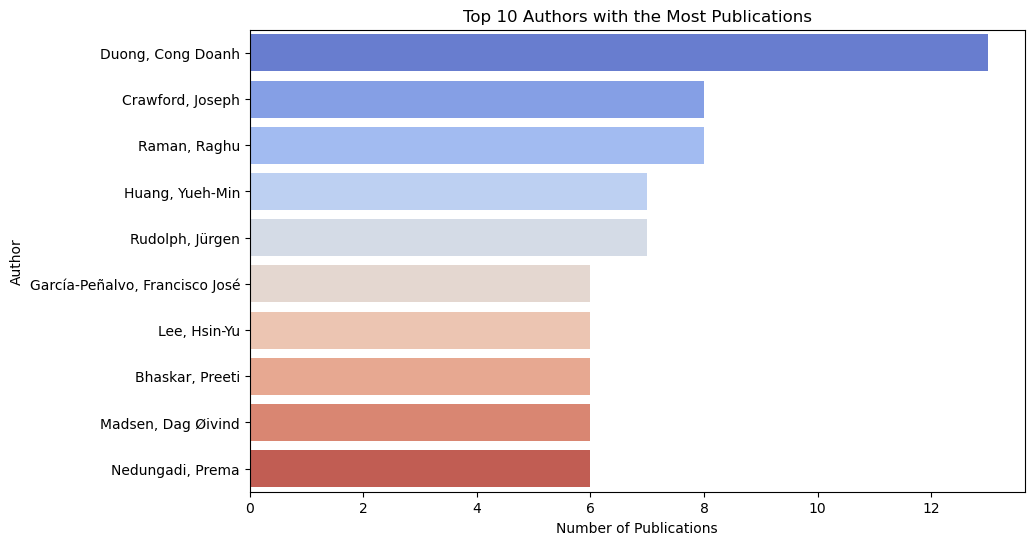

In [19]:
def plot_authors_with_most_publications(df):
    # Function to clean the names of the authors
    # They are stored like this: Kahlon, Yuval (57210749964);
    def clean_author_name(author_string):
        # regex to clean anything inside parentheses, parentheses included
        cleaned_name = re.sub(r'\(.*?\)', '', author_string).strip()
        return cleaned_name
    
    # The names are stored as a string, so we split them up in individual names so we can count them
    authors_list = df['Author full names'].dropna().apply(lambda x: [clean_author_name(author.strip()) for author in x.split(';')])
    all_authors = [author for sublist in authors_list for author in sublist]
    
    author_counts = pd.Series(all_authors).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=author_counts.values, y=author_counts.index, palette="coolwarm")
    plt.title("Top 10 Authors with the Most Publications")
    plt.xlabel("Number of Publications")
    plt.ylabel("Author")
    plt.show()

if CSV_DATA is not None:
    plot_authors_with_most_publications(CSV_DATA)
else:
    print("Please use CSV, as the API does not provide the necessary data to plot this information")

#### Most prominent institutions

C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\3597858278.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=institution_counts.values, y=institution_counts.index, palette="plasma")


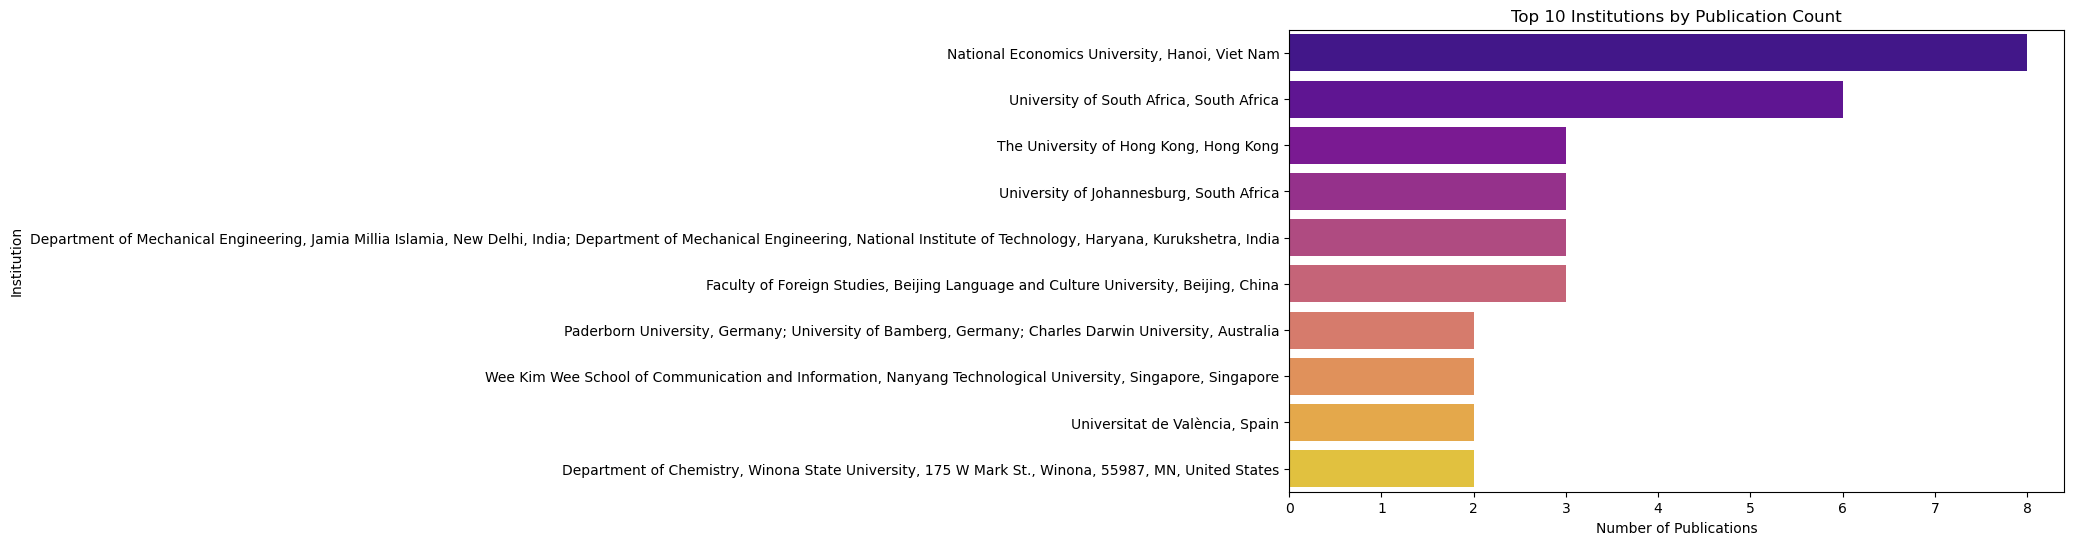

In [20]:
# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def plot_top_institutions(df, opt):
    all_institutions = []
    
    if opt == 0:
        for _, row in df.iterrows():
            affiliation = str(row['Affiliations']).strip()
            if affiliation and affiliation.lower() != 'nan':  
                all_institutions.append(affiliation)
    
    elif opt == 1:
        if isinstance(df, pd.DataFrame):
            df = df.to_dict('records')
            
        for item in df:
            if isinstance(item, dict): 
                affiliations = item.get('affiliations', [])
                for affiliation in affiliations:
                    institution = affiliation.get('name', '')
                    if institution:
                        all_institutions.append(institution)

    if not all_institutions:
        print("No valid affiliations found.")
        return

    institution_counts = pd.Series(all_institutions).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=institution_counts.values, y=institution_counts.index, palette="plasma")
    plt.title("Top 10 Institutions by Publication Count")
    plt.xlabel("Number of Publications")
    plt.ylabel("Institution")
    plt.show()

plot_top_institutions(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

#### Most prominent countries

C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\352796471.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=countries_counts.values, y=countries_counts.index, palette="plasma")


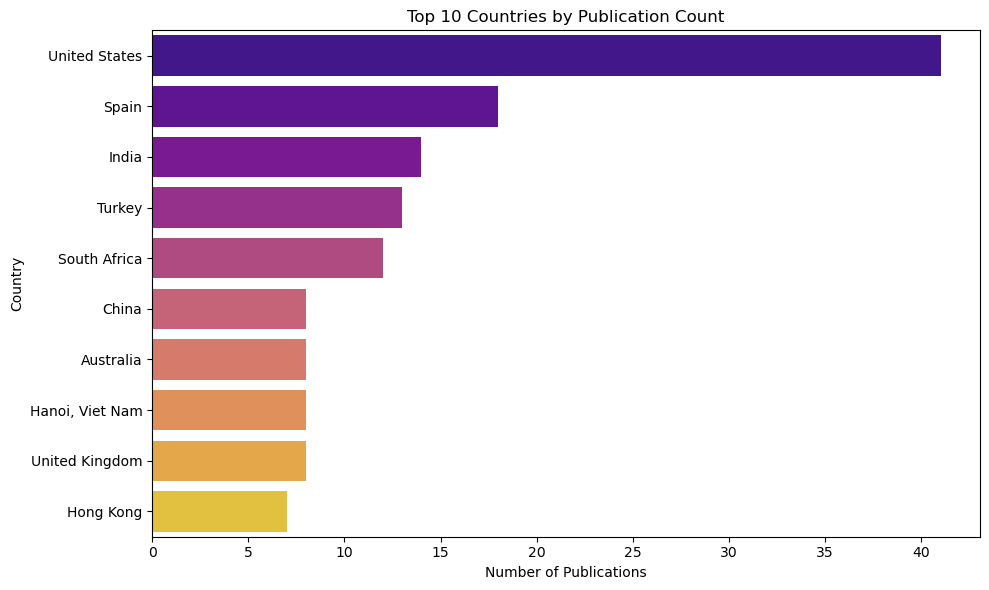

In [21]:
# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def extract_countries(df, opt):
    countries_list = []

    if opt == 0:
        for _, row in df.iterrows():
            affiliation = str(row['Affiliations']).strip()
            if affiliation and affiliation.lower() != 'nan':
                parts = affiliation.split(',', 1)
                if len(parts) > 1:
                    country = parts[1].strip()
                    countries_list.append(country)
    
    elif opt == 1:
        if isinstance(df, pd.DataFrame):
            df = df.to_dict('records')
            
        for item in df:
            if isinstance(item, dict):
                affiliations = item.get('affiliations', [])
                for affiliation in affiliations:
                    country = affiliation.get('country', '')
                    if country:
                        countries_list.append(country)

    return countries_list

# df -> dataset
# opt -> whether the data is from the csv or from the api, to know which column name to search for
def plot_top_countries(df, opt):
    if isinstance(df, list):
        df = pd.DataFrame(df)
    
    countries = extract_countries(df, opt)
    
    if countries:
        countries_counts = pd.Series(countries).value_counts().head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=countries_counts.values, y=countries_counts.index, palette="plasma")
        plt.title("Top 10 Countries by Publication Count")
        plt.xlabel("Number of Publications")
        plt.ylabel("Country")
        plt.tight_layout()
        plt.show()
    else:
        print("No country data found to plot")

plot_top_countries(CSV_DATA if CSV_DATA is not None else API_DATA, 0 if CSV_DATA is not None else 1)

#### Sponsorships and Funding
Only works with data from the CSV, has the standard API does not give data about the sponsorships

C:\Users\gilra\AppData\Local\Temp\ipykernel_20176\1819787799.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sponsors.values, y=top_sponsors.index, palette="cividis")


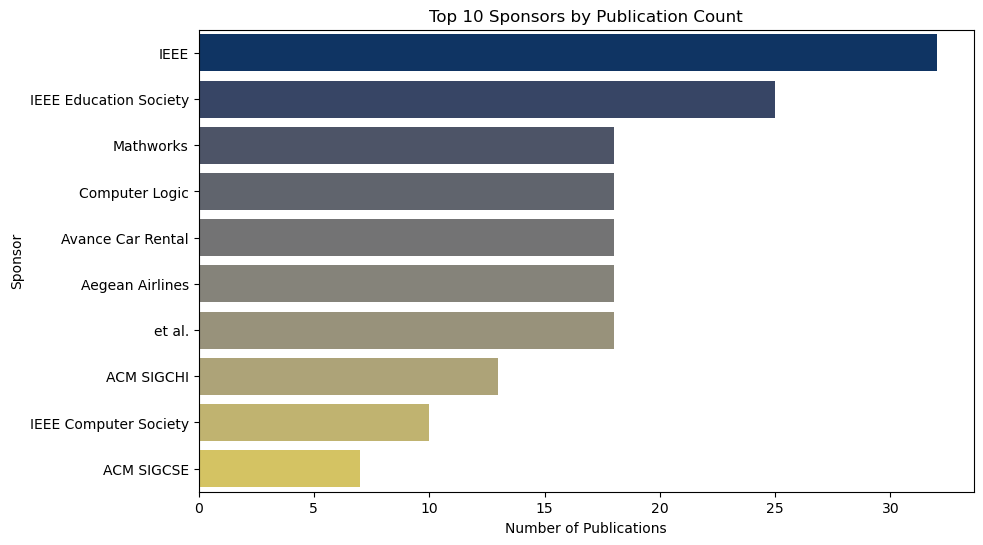

In [22]:
def plot_top_sponsors(df):
    all_sponsors = [sponsor.strip() for sponsors in df['Sponsors'].dropna() for sponsor in sponsors.split(';')]
    top_sponsors = pd.Series(all_sponsors).value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_sponsors.values, y=top_sponsors.index, palette="cividis")
    plt.title("Top 10 Sponsors by Publication Count")
    plt.xlabel("Number of Publications")
    plt.ylabel("Sponsor")
    plt.show()

if CSV_DATA is not None:
    plot_top_sponsors(CSV_DATA)
else:
    print("Please use CSV, as the API does not provide the necessary data to plot this information")

## Pre-Processing

*Import Libraries & Download NLTK Resources*

In [ ]:

import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.font_manager as fm

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### *Load Data*

In [ ]:
# Load CSV
data = pd.read_csv('../scopus.csv')

#### *Inspect Data*

In [ ]:
print(data['Abstract'])         # Inspect sample abstracts


0       This study evaluates the effectiveness of AI-d...
1       This study investigates how U.S. college stude...
2       Suicide remains a pressing global public healt...
3       ChatGPT, a sophisticated artificial intelligen...
4       Willingness to communicate (WTC) has been iden...
                              ...                        
2520    ChatGPT is a new generative artificial intelli...
2521                              [No abstract available]
2522    ChatGPT is an AI-based Natural Language Genera...
2523    With the launch of text-based artificial Intel...
2524    The education sector has benefited enormously ...
Name: Abstract, Length: 2525, dtype: object


#### ***Text Preprocessing***

In [ ]:
def advanced_text_preprocess(
    text, 
    lowercase=True, 
    remove_punctuation=True, 
    remove_numbers=True, 
    remove_stopwords=True, 
    lemmatize=True
):
    """
    Advanced text preprocessing function with configurable options
    
    Parameters:
    - text: Input text string
    - lowercase: Convert text to lowercase
    - remove_punctuation: Remove punctuation marks
    - remove_numbers: Remove numeric characters
    - remove_stopwords: Remove common stopwords
    - lemmatize: Apply lemmatization
    
    Returns:
    Preprocessed text string
    """
    # Ensure text is a string and not NaN
    if not isinstance(text, str):
        return ''
    
    # Lowercase conversion
    if lowercase:
        text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Return processed tokens as a string
    return ' '.join(tokens)


#### *Apply **Preprocessing** to Abstracts*

In [ ]:
# Basic usage
data['Processed_Abstract'] = data['Abstract'].apply(advanced_text_preprocess)

# Customized preprocessing
data['Custom_Processed'] = data['Abstract'].apply(
    lambda x: advanced_text_preprocess(
        x, 
        lowercase=True, 
        remove_numbers=False, 
        lemmatize=True
    )
)

#### *Processed Results*

In [ ]:
selected_columns = data[['Abstract', 'Processed_Abstract']]
selected_columns.head(20)

,Abstract,Processed_Abstract
0,This study evaluates the effectiveness of AI-d...,study evaluates effectiveness aidriven technol...
1,This study investigates how U.S. college stude...,study investigates u college student n perceiv...
2,Suicide remains a pressing global public healt...,suicide remains pressing global public health ...
3,"ChatGPT, a sophisticated artificial intelligen...",chatgpt sophisticated artificial intelligence ...
4,Willingness to communicate (WTC) has been iden...,willingness communicate wtc identified crucial...
5,Background: The past decade has witnessed a su...,background past decade witnessed surge develop...
6,Virtual reality (VR) with augmented reality (A...,virtual reality vr augmented reality ar drasti...
7,Generative artificial intelligence systems bas...,generative artificial intelligence system base...
8,Artificial intelligence (AI) can generate high...,artificial intelligence ai generate highqualit...
9,This article examines the incorporation of Ein...,article examines incorporation einsteinian phy...


#### *Wordcloud*

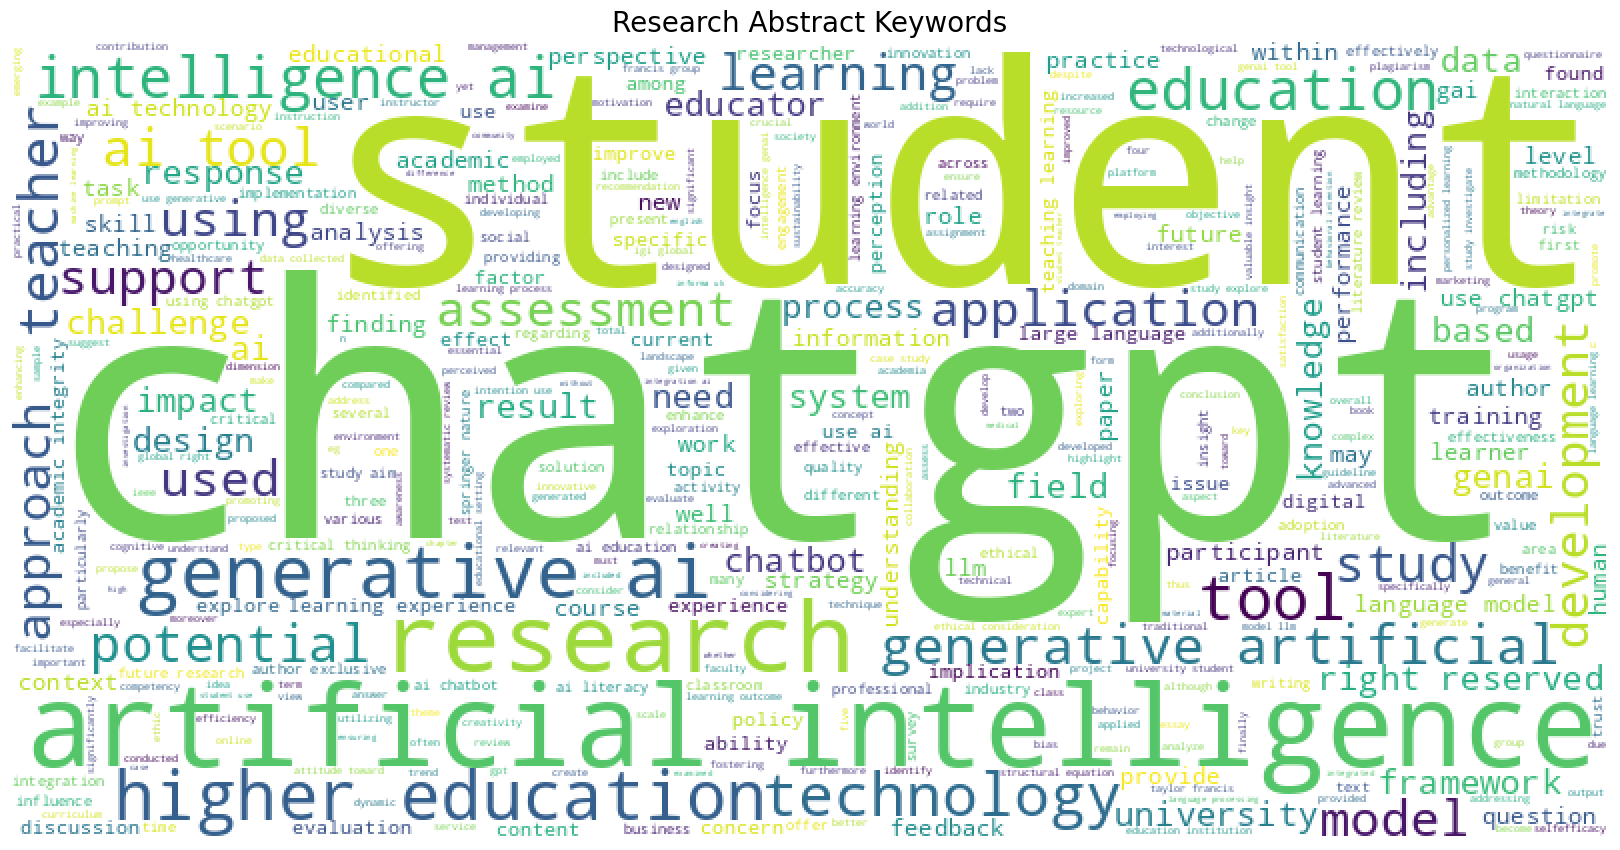

In [ ]:

def generate_wordcloud(text_series, title='Word Cloud', max_words=10000, background_color='white'):
    """
    Generate a word cloud from a pandas Series of text
    
    Parameters:
    - text_series: Pandas Series containing processed text
    - title: Title of the word cloud
    - max_words: Maximum number of words to display
    - background_color: Background color of the word cloud
    """

    # Combine all text into a single string
    text = ' '.join(text_series.dropna())
    
    # Create WordCloud object
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color=background_color, 
        max_words=max_words,
        stopwords = STOPWORDS,
        colormap='viridis'  
    ).generate(text)
    
    # Create the plot
    plt.figure(figsize=(16,10), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()


generate_wordcloud(data['Processed_Abstract'], title='Research Abstract Keywords')

#### *Import Libraries*

In [ ]:
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### ***Bag-of-Words***
(Represents text as a vector of word counts, ignoring grammar and word order.)

In [ ]:
# Create Bag of Words representation
bow_vectorizer = CountVectorizer(max_features=1000)
bow_features = bow_vectorizer.fit_transform(data['Processed_Abstract'])

# Convert to DataFrame for easier viewing
bow_df = pd.DataFrame(
    bow_features.toarray(), 
    columns=bow_vectorizer.get_feature_names_out()
)

print(bow_df)

      ability  able  abstract  academia  academic  acceptance  access  \
0           1     0         0         0         0           0       0   
1           0     0         0         0         1           0       0   
2           1     0         0         0         0           0       0   
3           0     0         0         0         1           0       0   
4           0     0         0         0         0           0       0   
...       ...   ...       ...       ...       ...         ...     ...   
2520        0     1         0         1         0           0       0   
2521        0     0         1         0         0           0       0   
2522        0     0         0         0         0           0       0   
2523        0     0         0         0         0           0       0   
2524        0     0         0         0         0           0       0   

      accessibility  according  accuracy  ...  word  work  working  workplace  \
0                 0          0         0  

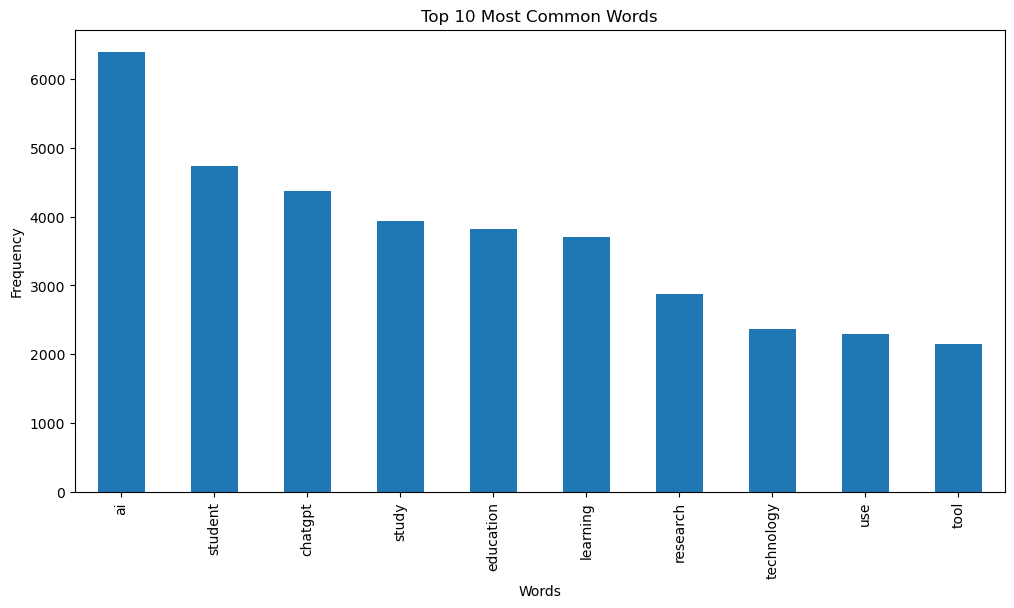

In [ ]:
# Sum up the counts of each word
sum_words = bow_df.sum(axis=0)

# Sort and select top 10 words
sorted_words = sum_words.sort_values(ascending=False)[:10]

# Plot
plt.figure(figsize=(12, 6))
sorted_words.plot(kind='bar')
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

### ***TF-IDF***
(Statistical measure that evaluates the importance of a word in a document relative to a collection of documents (corpus).

In [ ]:
# Create TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(data['Processed_Abstract'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_features.toarray(), 
    columns=tfidf_vectorizer.get_feature_names_out()
)



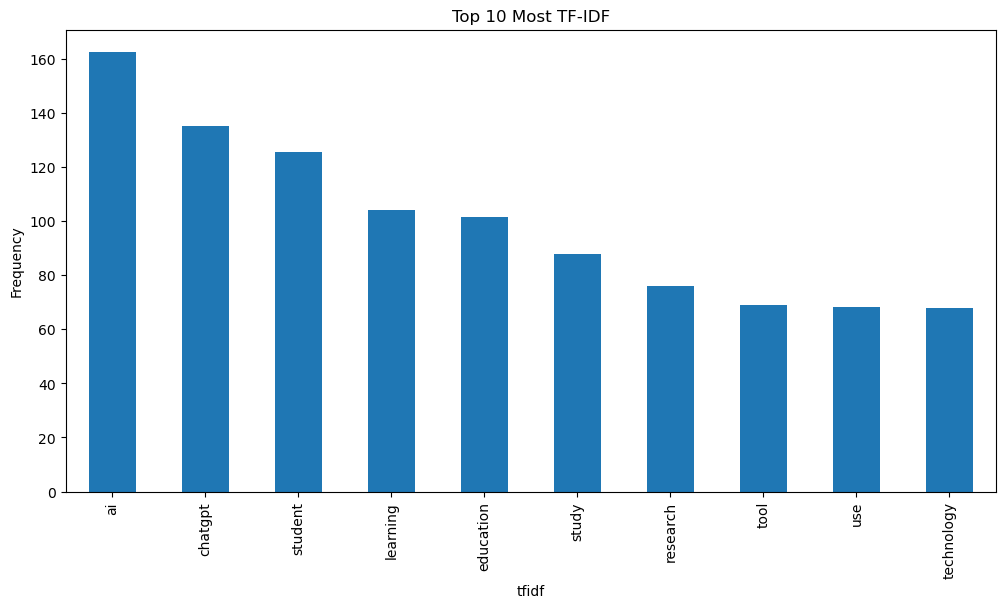

In [ ]:
# Sum up the counts of each bigram
sum_tfidf = tfidf_df.sum(axis=0)

# Sort and select top 10 bigrams
sorted_tfidf = sum_tfidf.sort_values(ascending=False)[:10]

# Plot
plt.figure(figsize=(12, 6))
sorted_tfidf.plot(kind='bar')
plt.title('Top 10 Most TF-IDF')
plt.xlabel('tfidf')
plt.ylabel('Frequency')
plt.show()

### ***N-Grams***
(Generate N-Grams to analyze word combinations in the abstracts)

In [ ]:
ngram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),  # Include unigrams and bigrams
    max_features=1000
)
ngram_features = ngram_vectorizer.fit_transform(data['Processed_Abstract'])

ngram_df = pd.DataFrame(ngram_features.toarray(), columns=ngram_vectorizer.get_feature_names_out())


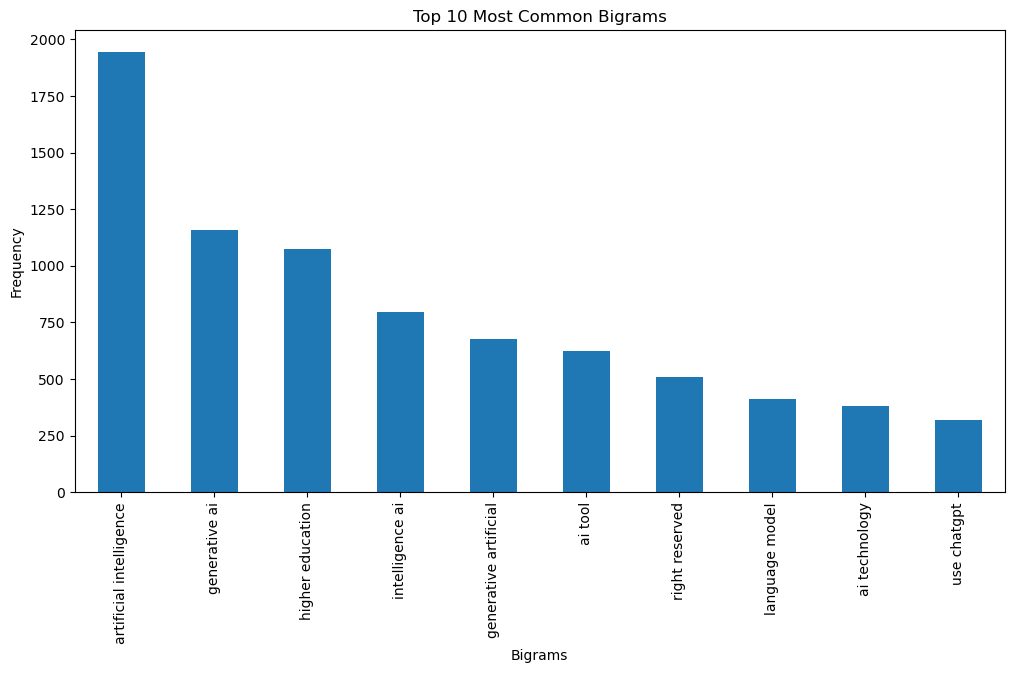

In [ ]:
# Sum up the counts of each bigram
sum_bigrams = ngram_df.sum(axis=0)

# Sort and select top 10 bigrams
sorted_bigrams = sum_bigrams.sort_values(ascending=False)[:10]

# Plot
plt.figure(figsize=(12, 6))
sorted_bigrams.plot(kind='bar')
plt.title('Top 10 Most Common Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.show()


#### ***Part Of Speech Tagging***
(Label each token with its grammatical category)

In [ ]:
# Function to tag POS in a sentence
def pos_tag_sentence(sentence):
    tokens = word_tokenize(sentence)
    return pos_tag(tokens)

# Apply POS tagging to each cleaned abstract
data['POS_Tagged_Abstract'] = data['Processed_Abstract'].apply(pos_tag_sentence)

# Display the DataFrame
#print(data[['Processed_Abstract', 'POS_Tagged_Abstract']].head())


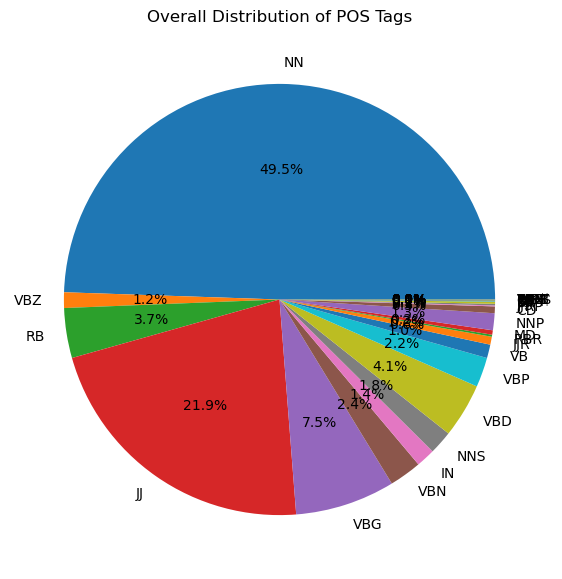

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import itertools

# Flatten the list of all POS tags from all abstracts
all_tags = list(itertools.chain.from_iterable(data['POS_Tagged_Abstract'].apply(lambda x: [tag for word, tag in x])))

# Count the frequency of each POS tag
tag_freq = Counter(all_tags)

# Create a pie chart
plt.figure(figsize=(7, 7))
plt.pie(tag_freq.values(), labels=tag_freq.keys(), autopct='%1.1f%%')
plt.title('Overall Distribution of POS Tags')
plt.show()


#### ***Another Advanced Features:***
- ***Word Count***: The total number of words in the text.
- ***Unique Word Count:*** The number of unique words in the text.
- ***Average Word Length***: The average length of words in the text.
- ***Text Complexity***: The ratio of the total text length to the number of words.
- ***Word Length Standard Deviation***: The standard deviation of word lengths, indicating word length variation.
- ***Vocabulary Richness***: The ratio of unique words to total words, indicating lexical diversity.


In [ ]:
def enhanced_advanced_features(text):
    words = text.split()
    if not words:
        return {
            'word_count': 0,
            'unique_word_count': 0,
            'avg_word_length': 0,
            'text_complexity': 0,
            'word_length_std': 0,
            'vocabulary_richness': 0
        }
    
    return {
        'word_count': len(words),
        'unique_word_count': len(set(words)),
        'avg_word_length': np.mean([len(word) for word in words]),
        'text_complexity': len(text) / len(words),
        'word_length_std': np.std([len(word) for word in words]),  # Word length variation
        'vocabulary_richness': len(set(words)) / len(words)  # Lexical diversity ratio
    }

# Apply advanced feature extraction
advanced_features = data['Processed_Abstract'].apply(enhanced_advanced_features).apply(pd.Series)


#### ***Vizualization***:

***Word Count Distribution*** - A histogram showing the distribution of the total number of words in the abstracts.

***Unique vs Total Words*** - A scatter plot comparing the number of unique words to the total number of words.

***Average Word Length Distribution*** - A histogram showing the distribution of the average word length.

***Text Complexity Distribution*** - A histogram showing the distribution of text complexity.

***Vocabulary Richness*** - A histogram showing the distribution of vocabulary richness.

***Word Length Variation*** - A histogram showing the distribution of the standard deviation of word lengths.

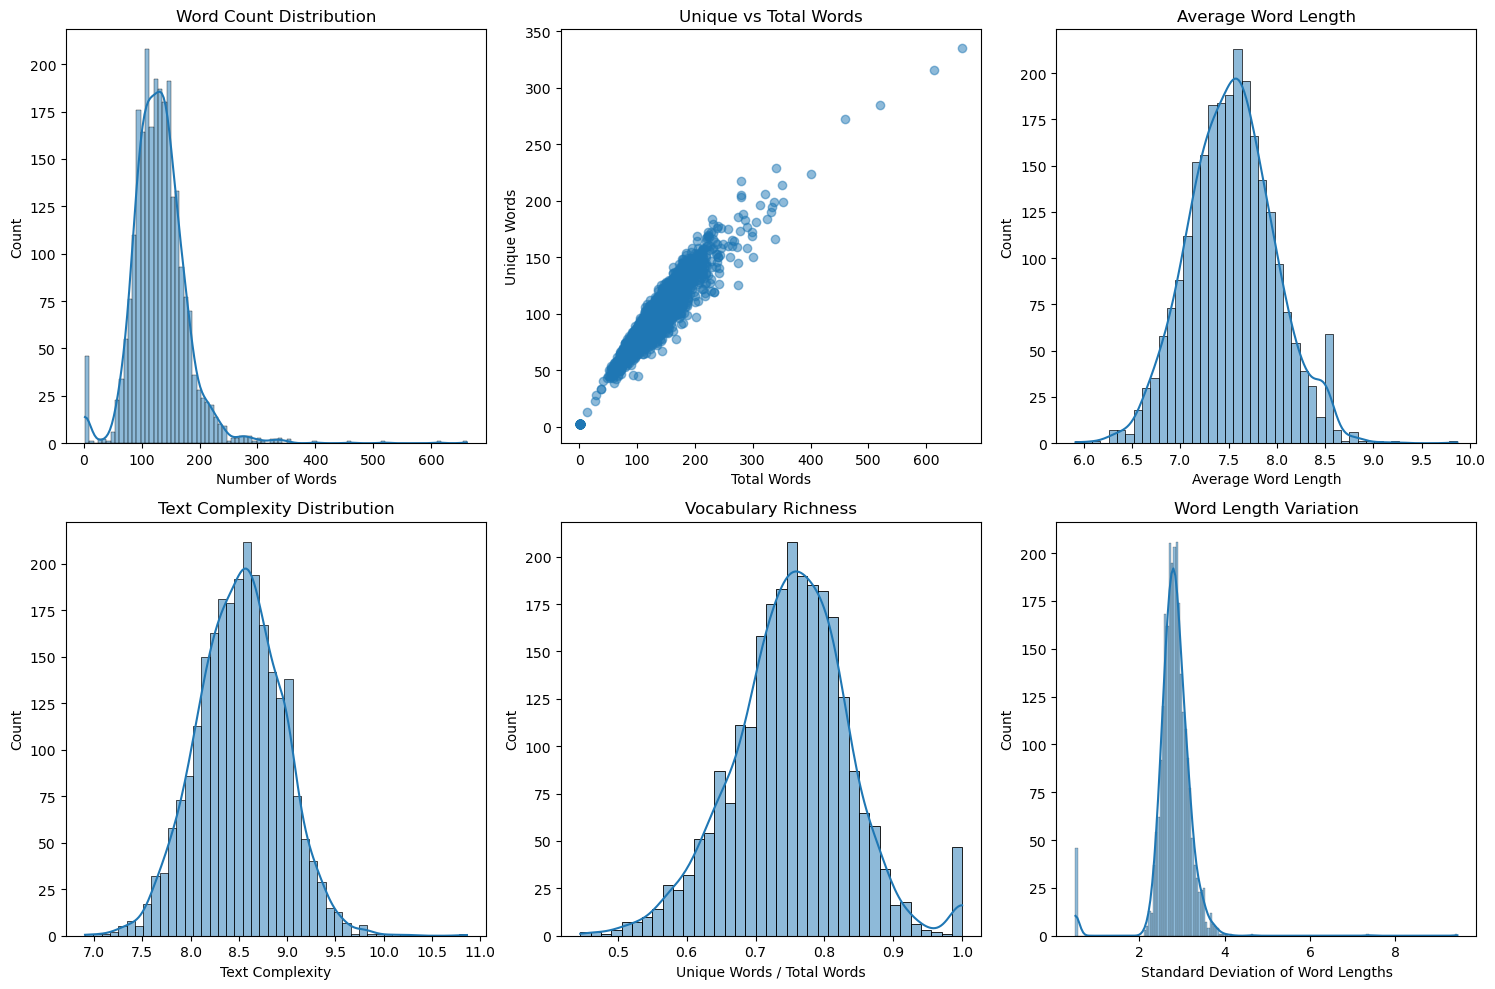

In [ ]:
# Create visualizations
plt.figure(figsize=(15,10))

# 1. Distribution of Word Count
plt.subplot(2, 3, 1)
sns.histplot(advanced_features['word_count'], kde=True)
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')

# 2. Unique Word +Count vs Total Word Count
plt.subplot(2, 3, 2)
plt.scatter(advanced_features['word_count'], advanced_features['unique_word_count'], alpha=0.5)
plt.title('Unique vs Total Words')
plt.xlabel('Total Words')
plt.ylabel('Unique Words')

# 3. Average Word Length Distribution
plt.subplot(2, 3, 3)
sns.histplot(advanced_features['avg_word_length'], kde=True)
plt.title('Average Word Length')
plt.xlabel('Average Word Length')

# 4. Text Complexity Distribution
plt.subplot(2, 3, 4)
sns.histplot(advanced_features['text_complexity'], kde=True)
plt.title('Text Complexity Distribution')
plt.xlabel('Text Complexity')

# 5. Vocabulary Richness
plt.subplot(2, 3, 5)
sns.histplot(advanced_features['vocabulary_richness'], kde=True)
plt.title('Vocabulary Richness')
plt.xlabel('Unique Words / Total Words')

# 6. Word Length Standard Deviation
plt.subplot(2, 3, 6)
sns.histplot(advanced_features['word_length_std'], kde=True)
plt.title('Word Length Variation')
plt.xlabel('Standard Deviation of Word Lengths')

plt.tight_layout()
plt.show()

# Additional statistical summary
#print(advanced_features.describe())

# Modelling

Import Libraries

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.coherencemodel import CoherenceModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Tokenize the processed text

In [ ]:
data['tokenized_Abstract'] = data['Processed_Abstract'].apply(lambda x: x.split())

Dictionary and Corpus creation

In [ ]:
dictionary = Dictionary(data['tokenized_Abstract'])
corpus = [dictionary.doc2bow(text) for text in data['tokenized_Abstract']]

### LDA Model Implementation

Coherence score - How semantically meaningful the discovered topics are

In [ ]:
#LDA Model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(f'Topic {topic[0]}: Words: {topic[1]}')

# Compute coherence score
coherence_model = CoherenceModel(model=lda_model, texts=data['tokenized_Abstract'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'\nCoherence Score: {coherence_score}')

Topic 0: Words: 0.032*"ai" + 0.023*"education" + 0.016*"learning" + 0.013*"research"
Topic 1: Words: 0.009*"technology" + 0.008*"ai" + 0.008*"social" + 0.008*"business"
Topic 2: Words: 0.015*"chatgpt" + 0.012*"model" + 0.010*"learning" + 0.009*"data"
Topic 3: Words: 0.028*"student" + 0.020*"chatgpt" + 0.011*"ai" + 0.011*"tool"
Topic 4: Words: 0.023*"chatgpt" + 0.023*"student" + 0.021*"study" + 0.012*"learning"

Coherence Score: 0.3815015528554445


### Topic Model Visualization

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(
    lda_model, 
    corpus, 
    dictionary,
    R=10        # Number of top words to display per topic
)
pyLDAvis.display(vis)

Document topics

In [ ]:
def get_document_topics(doc_bow):
    doc_topics = lda_model.get_document_topics(doc_bow)
    return [topic_prob for topic_id, topic_prob in doc_topics]

data['document_topics'] = data['tokenized_Abstract'].apply(lambda x: dictionary.doc2bow(x)).apply(get_document_topics)


Dominant topics

In [ ]:
def get_dominant_topic(doc_bow):
    doc_topics = lda_model.get_document_topics(doc_bow)
    if doc_topics:
        dominant_topic = max(doc_topics, key=lambda x: x[1])  # Find topic with max probability
        return dominant_topic[0], dominant_topic[1]  # Return topic ID and probability
    return None, 0  # Handle empty documents

data[['dominant_topic', 'dominant_prob']] = data['tokenized_Abstract'].apply(
    lambda x: get_dominant_topic(dictionary.doc2bow(x))
).apply(pd.Series)


Relevant Topics

In [ ]:
def get_relevant_topics(doc_bow, threshold=0.1):
    doc_topics = lda_model.get_document_topics(doc_bow)
    return {topic_id: topic_prob for topic_id, topic_prob in doc_topics if topic_prob > threshold}

data['relevant_topics'] = data['tokenized_Abstract'].apply(lambda x: dictionary.doc2bow(x)).apply(get_relevant_topics)


Topics Wordcloud

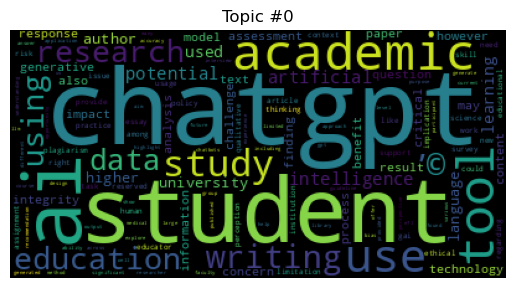

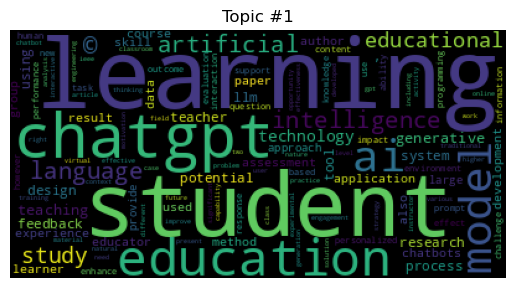

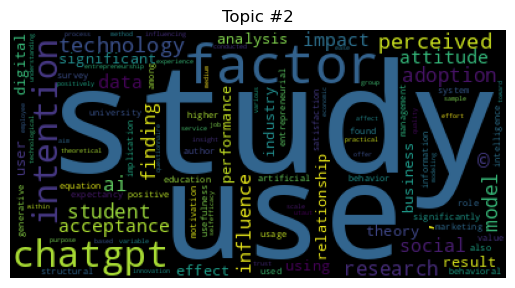

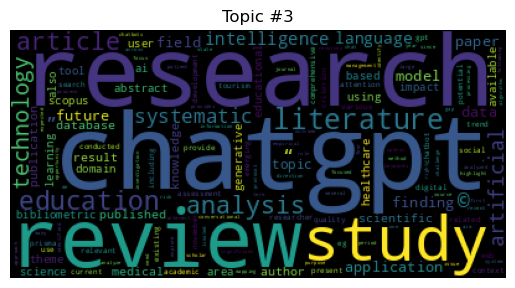

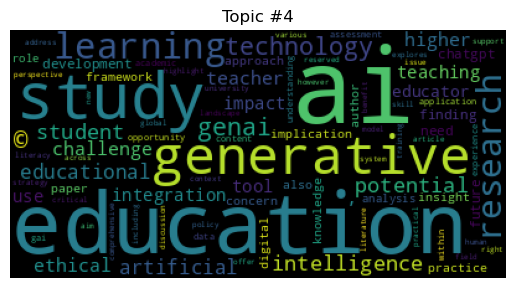

In [ ]:
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()


## Clustering

Number of K Clusters

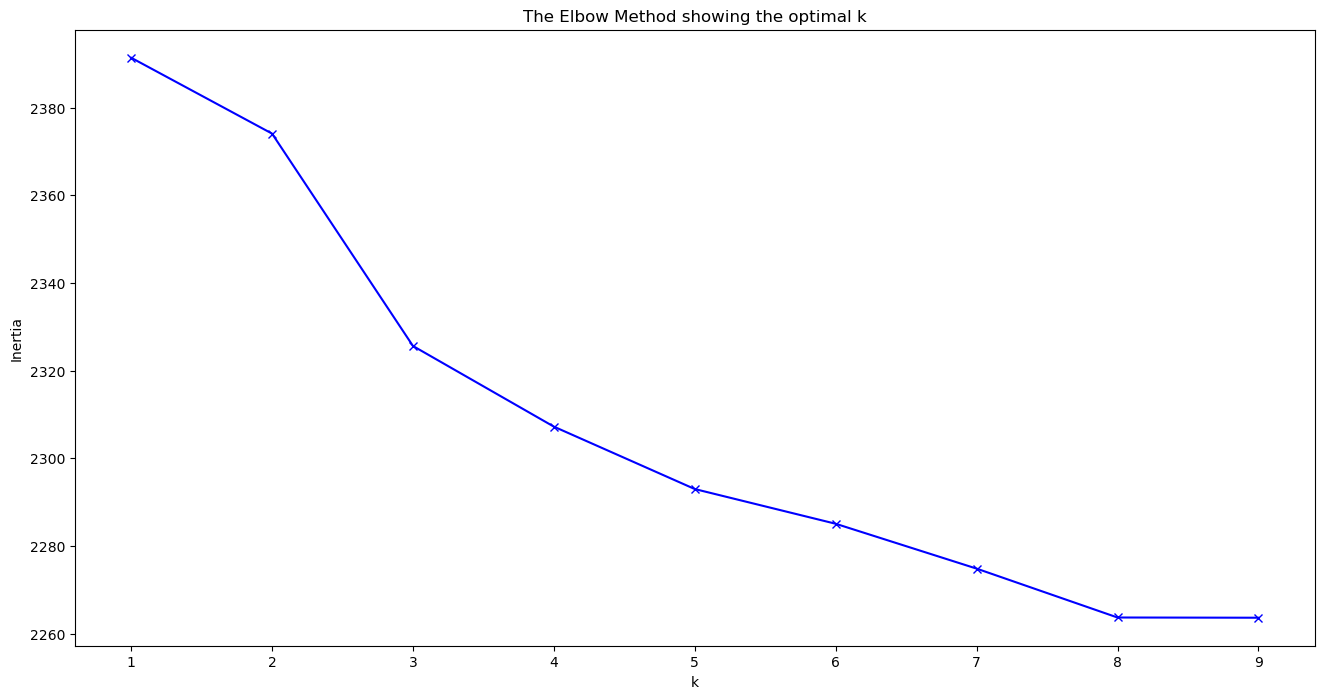

In [ ]:
# Elbow Method
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()


The optimal K number seems to be 'K=3'

In [ ]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(tfidf_df)
data['Cluster'] = clusters


In [ ]:
for i in range(3):
    print(f"Cluster {i}:")
    print(data[data['Cluster'] == i]['Processed_Abstract'])


Cluster 0:
58      abstract available
66      abstract available
187     abstract available
319     abstract available
353     abstract available
410     abstract available
464     abstract available
471     abstract available
481     abstract available
500     abstract available
601     abstract available
626     abstract available
657     abstract available
684     abstract available
768     abstract available
771     abstract available
777     abstract available
838     abstract available
879     abstract available
1040    abstract available
1076    abstract available
1090    abstract available
1169    abstract available
1349    abstract available
1764    abstract available
1946    abstract available
2008    abstract available
2016    abstract available
2080    abstract available
2100    abstract available
2111    abstract available
2207    abstract available
2208    abstract available
2219    abstract available
2236    abstract available
2246    abstract available
2256    abstract 

### Clustering - from the topics

In [ ]:
# Topic distribution for each document
doc_topic_dist = [lda_model.get_document_topics(bow) for bow in corpus]

# Initialize a matrix with zeros
doc_topic_matrix = np.zeros((len(doc_topic_dist), lda_model.num_topics))

# Populate the matrix
for i, doc in enumerate(doc_topic_dist):
    for topic, prob in doc:
        doc_topic_matrix[i, topic] = prob


In [ ]:
# Perform K-means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(doc_topic_matrix)

# Adding cluster labels to the original DataFrame
data['Topic_Cluster'] = clusters


# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(doc_topic_matrix, clusters)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.3296018906474815


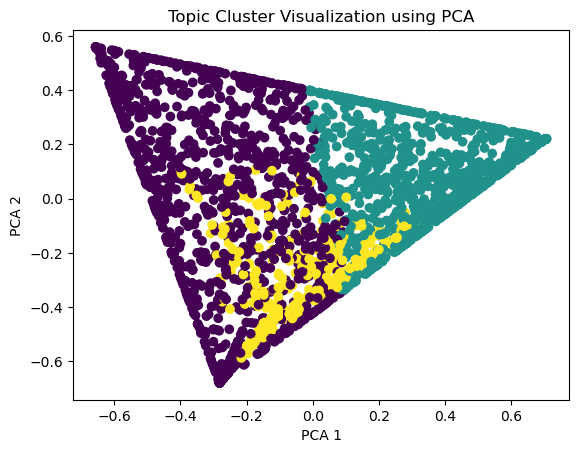

In [ ]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(doc_topic_matrix)

# Plot the clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Topic Cluster Visualization using PCA')
plt.show()


In [ ]:
# Analyze clusters (3)
for i in range(3):
    print(f"Cluster {i}:")
    print(data[data['Topic_Cluster'] == i]['Processed_Abstract'])


Cluster 0:
1       study investigates u college student n perceiv...
3       chatgpt sophisticated artificial intelligence ...
4       willingness communicate wtc identified crucial...
5       background past decade witnessed surge develop...
6       virtual reality vr augmented reality ar drasti...
                              ...                        
2520    chatgpt new generative artificial intelligence...
2521                                   abstract available
2522    chatgpt aibased natural language generation nl...
2523    launch textbased artificial intelligence ai po...
2524    education sector benefited enormously integrat...
Name: Processed_Abstract, Length: 1155, dtype: object
Cluster 1:
0       study evaluates effectiveness aidriven technol...
2       suicide remains pressing global public health ...
9       article examines incorporation einsteinian phy...
13      recent research university mathematics educati...
17      faculty perspective use artificial intelligenc

### Hierarchical Clustering

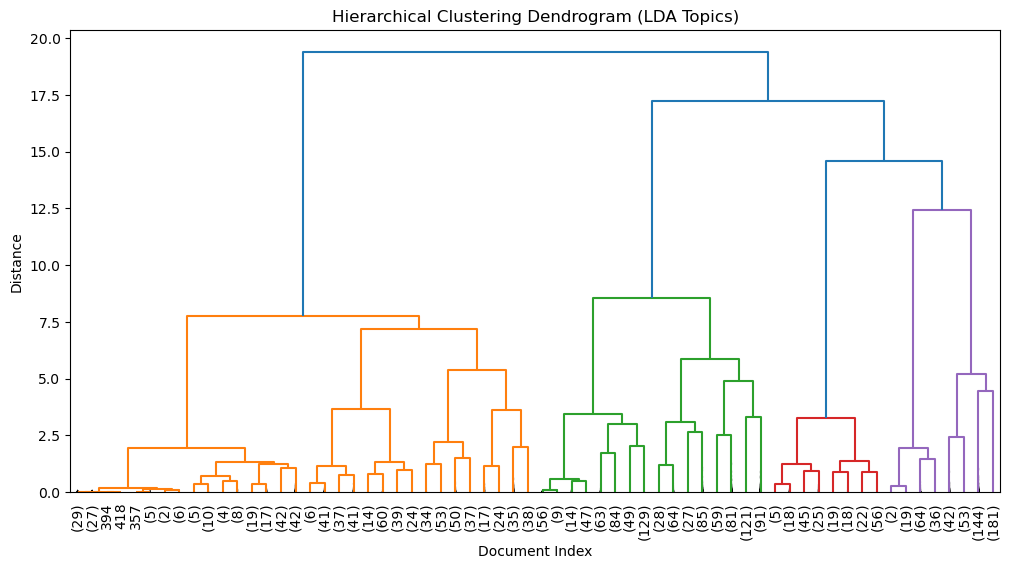

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Create the linkage matrix using the Ward method (minimizes variance within clusters)
linkage_matrix = linkage(doc_topic_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=5,                    
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)
plt.title("Hierarchical Clustering Dendrogram (LDA Topics)")
plt.xlabel("Document Index")
plt.ylabel("Distance")
plt.show()


Assign Cluster Labels

In [ ]:
from scipy.cluster.hierarchy import fcluster

num_clusters = 3
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the dataset
data['hierarchical_cluster'] = clusters
print(data[['Processed_Abstract', 'hierarchical_cluster']].head())


                                  Processed_Abstract  hierarchical_cluster
0  study evaluates effectiveness aidriven technol...                     1
1  study investigates u college student n perceiv...                     3
2  suicide remains pressing global public health ...                     2
3  chatgpt sophisticated artificial intelligence ...                     3
4  willingness communicate wtc identified crucial...                     2


#### Visualize Clusters using t-SNE

c:\Users\david\miniconda3\envs\ICD2425\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


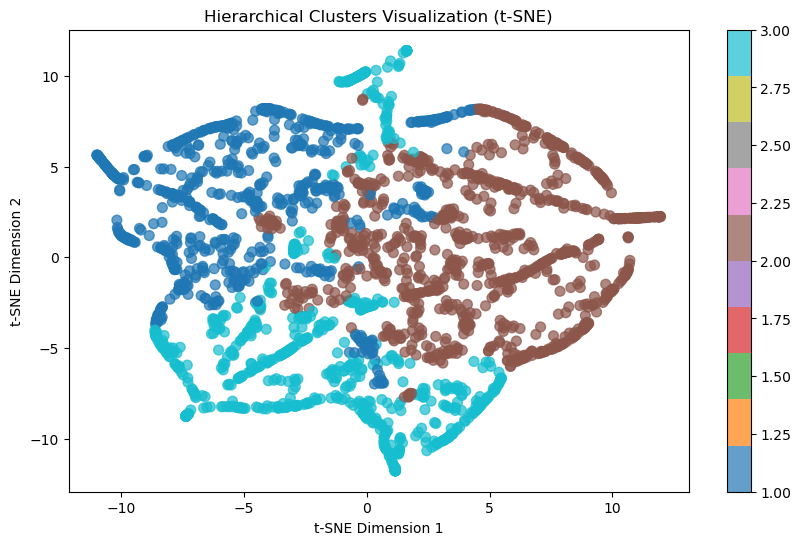

In [ ]:
from sklearn.manifold import TSNE

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(doc_topic_matrix)

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='tab10', s=50, alpha=0.7)
plt.colorbar()
plt.title("Hierarchical Clusters Visualization (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [ ]:
# Find dominant topics within each cluster
for cluster_id in range(1, num_clusters + 1):
    cluster_docs = data[data['hierarchical_cluster'] == cluster_id]
    topic_means = np.mean(
        doc_topic_matrix[cluster_docs.index], axis=0
    )  # Mean topic probabilities for the cluster
    print(f"Cluster {cluster_id}: Dominant Topics: {np.argsort(-topic_means)[:3]}")  # Top 3 topics


Cluster 1: Dominant Topics: [1 4 0]
Cluster 2: Dominant Topics: [4 0 1]
Cluster 3: Dominant Topics: [0 2 3]


### Heatmap of Topic Distributions

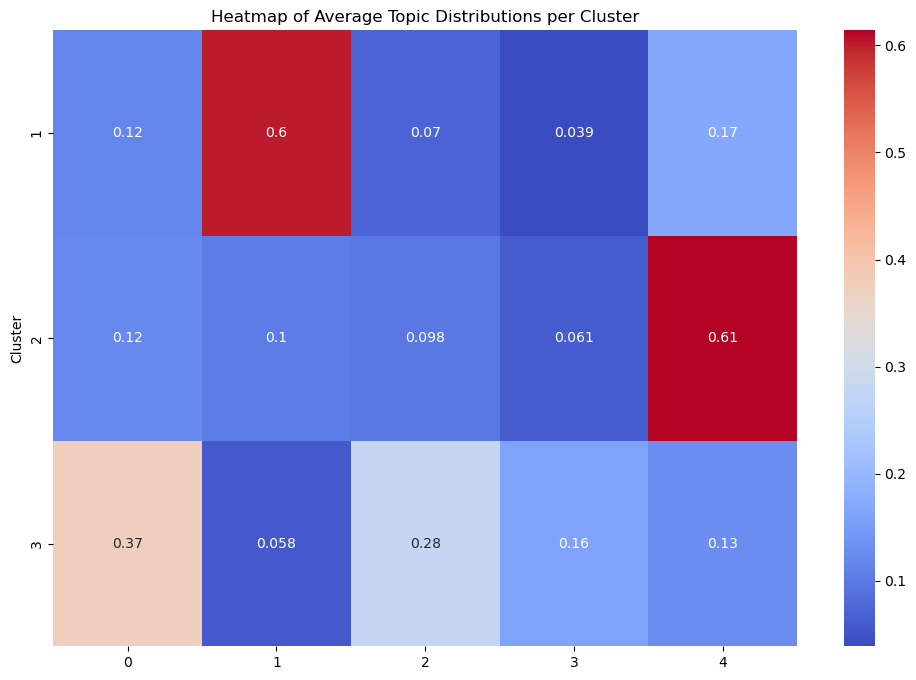

In [ ]:
# DataFrame of the topic distribution matrix and cluster labels
topic_df = pd.DataFrame(doc_topic_matrix)
topic_df['Cluster'] = clusters

# Mean topic distribution for each cluster
cluster_means = topic_df.groupby('Cluster').mean()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Heatmap of Average Topic Distributions per Cluster')
plt.show()
